In [1]:
# #Astropy
# import astropy
# from astropy.io import fits
# from astropy.table import Table

# # Matplotlib
# import matplotlib
# import matplotlib.pyplot as plt
# # %matplotlib inline
# matplotlib.rcParams.update({'font.size': 25})

# #Numpy/Scipy
# import numpy as np
# from scipy.interpolate import InterpolatedUnivariateSpline as IUS
# from scipy.optimize import curve_fit

# class Aetas():
#     '''
#     A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
#     from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
#     '''
#     def __init__(self,teffarr,feharr,photarr,distance,isochrones,rv=3.1):
        
#         '''
#         teff: [array] Teff and error of star np.array([teff,teff_err])
#         abund: [array] [Fe/H],[C/Fe],[N/Fe],[Alpha/Fe]
#         obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
#         distance: [float] distance to star in pc
#         isochrones: [astropy Table] PARSEC isochrone table
#         rv: [float] Rv value (=Av/E(B_V)) 
#         '''

#         # Observed Quantities
#         self.teff = teffarr[0] # temperature
#         self.teff_err = teffarr[1] # temperature error
        
#         self.phot = photarr[:,0] # photometry
#         self.phot_err = photarr[:,1] # photometry errors
        
#         # Salaris Corrected Metallicity
# #         asplund = np.array([8.69,7.93,7.60,7.51,7.12,6.34,4.95]) # Asplund et al. 2009
# #         mass_ratio = np.array([15.999,20.1797,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC    
# #         ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
# #         XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
#         sal_a = 0.638 #np.sum(XZ_k)
#         sal_b = 0.362 #1 - sal_a
        
#         self.salfeh = feharr[0,0]+np.log10(sal_a*10**feharr[0,1]+sal_b)
#         self.salfeharr = np.sqrt(feharr[0,1]**2+((1-sal_b/(sal_a*10**feharr[0,1]+sal_b))*feharr[1,1])**2)
        
#         # Distance modulus
#         self.distance = distance
#         self.distmod = 5.0*np.log10(distance)-5.0
        
#         # PARSEC isochrones
#         self.rv = rv
#         self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
#         self.uniq_ages = np.unique(isochrones['logAge'])
#         self.grid_sep = np.median(np.diff(10**self.uniq_ages/10**9)) # in Gyr
#         self.max_age = 10**np.max(self.uniq_ages)/10**9 # in Gyr
        
#         self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
#         age_idx = []
#         for i in range(len(self.uniq_ages)):
#             ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
#             age_idx.append(np.array([min(ages),max(ages)]))
        
#         self.age_idx = np.asarray(age_idx)
                
#         # Effective Wavelengths of different passbands in units of microns
#         self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}

#     def closest(self,data,value):
#         '''
#         Find nearest value in array to given value

#         Inputs:
#         ------
#             data: data to search through 
#             value: value of interest
#         '''

#         data = np.asarray(data)

#         return data[(np.abs(np.subtract(data,value))).argmin()]

#     def neighbors(self,data,value):
#         '''
#         Find values of two elements closest to the given value

#         Inputs:
#         ------
#             data: data to search through 
#             value: value of interest

#         Output:
#         ------
#             close1: closest value under the given value
#             close2: closest value over the given value
#         '''

#         data = np.asarray(data)
#         close1 = data[(np.abs(np.subtract(data,value))).argmin()]
#         data = data[np.where(data!=close1)]
#         close2 = data[(np.abs(np.subtract(data,value))).argmin()]

#         return close1,close2

#     def mad(self,data):
#         '''
#         Calculate the median absolute deviation of the data
#         '''
#         return np.nanmedian(np.abs(data-np.nanmedian(data)))

#     def ccm_a(self,x):
#         '''
#         a(x) function from ccm et al. 1989

#         Input:
#         -----
#             x: effective wavelength in units of 1/micron

#         Output:
#         ------
#             a: a function value  
#         '''
#         if 0.3 <= x < 1.1:
#             a = 0.574*(x**1.61)
#             return a

#         elif 1.1 <= x < 3.3:
#             y = x - 1.82
#             a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
#                  0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
#             return a

#         elif 3.3 <= x < 8.0:
#             if x < 5.9:
#                 a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
#                 return a

#             else:
#                 fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
#                 a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
#                 return a       

#     def ccm_b(self,x):
#         '''
#         b(x) function from ccm et al. 1989

#         Input:
#         -----
#             x: effective wavelength in units of 1/micron

#         Output:
#         ------
#             b: b function value 
#         '''
#         if 0.3 <= x < 1.1:
#             b = -0.527*(x**1.61)
#             return b

#         elif 1.1 <= x <= 3.3:
#             y = x - 1.82
#             b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
#                  0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
#             return b

#         elif 3.3 <= x < 8.0:
#             if x < 5.9:
#                 b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
#                 return b

#             else:
#                 fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
#                 b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
#                 return b

#     def ccm_alav(self,wave):
#         '''
#         Calculate A\lambda/Av

#         Inputs:
#         ------
#             wave: effective wavelength in units of micron

#         Output:
#         ------
#             alav: A\lambda/Av
#         '''
#         x=1/wave
#         alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
#         return alav
    
#     def get_ak(self,age,verbose=False):
#         '''
#         Calculate the K band (fiducial band here) extintion by interpolating color index as a function
#         of temperature for a given age.

#         Inputs:
#         ------
#         age: [float] age in Gyr

#         Output:
#         ------
#         ak: extinction in the K band
#         '''

#         #Some calcualtions to set things up
#         nsamples = 100
#         ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
#         lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
#         akdist = 999999.0*np.ones(nsamples)

#         ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
#               self.ccm_alav(self.leff['Ksmag']))
#         erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
#               self.ccm_alav(self.leff['Ksmag']))
#         ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
#              self.ccm_alav(self.leff['Ksmag']))
#         ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
#              self.ccm_alav(self.leff['Ksmag']))

#         ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

#         lgage = np.log10(age*10**9)

#         if verbose:
#             print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])
        
#         for j in range(nsamples):
#             # Figure out if age is actually in the ages given in the isochrone table
#             if lgage in self.uniq_ages:

#                 ### pick out a single isochrone 
#                 aidx, = np.where(self.uniq_ages==lgage)
#                 iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

#                 if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
#                     if verbose:
#                         print('Ak: ',999999.0)
#                     akdist[j] = 999999.0

#                 ### sort so temp is always increasing
#                 sidx = np.argsort(iso_['logTe'])
#                 slogTe = iso_['logTe'][sidx]
#                 _, uidx = np.unique(slogTe,return_index=True)
#                 slogTe = slogTe[uidx]

#                 ### use a spline to get the intrinsic color and calculate the reddening
#                 calc_reds = 999999.*np.ones(4)
#                 for i in range(4):
#                     color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
#                     calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteffdist[j])

#                 ### calculate the Ak value
#                 calc_ak = np.median(np.divide(calc_reds,ccm))

#                 if verbose:
#                     print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
#                     print(ccm)
#                     print(np.divide(calc_reds,ccm))
#                     print('Calc Ak: ',calc_ak)
#                 akdist[j] = calc_ak

#             else:
#                 lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#                 if verbose:
#                     print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

#                 ### Pick out single isochrones

#                 # younger
#                 aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#                 iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

#                 # older
#                 aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#                 iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

#                 ### Temperature Check
#                 if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
#                     if verbose:
#                         print('Ak: ',999999.0)   
#                     akdist[j] = 999999.0
#                 if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
#                     if verbose:
#                         print('Ak: ',999999.0)
#                     akdist[j] = 999999.0

#                 ### sort so temp is always increasing

#                 # younger
#                 sidx_lo = np.argsort(iso_lo['logTe'])
#                 slogTe_lo = iso_lo['logTe'][sidx_lo]
#                 _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#                 slogTe_lo = slogTe_lo[uidx_lo]

#                 # older
#                 sidx_hi = np.argsort(iso_hi['logTe'])
#                 slogTe_hi = iso_hi['logTe'][sidx_hi]
#                 _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#                 slogTe_hi = slogTe_hi[uidx_hi]

#                 ### use a spline to get the apparent mags
#                 age_lo = 10**lgage_lo/10**9
#                 age_hi = 10**lgage_hi/10**9
#                 calc_reds = 999999.*np.ones(4)
#                 for i in range(4):
#                     color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
#                     color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
#                     age_spl_interp = np.poly1d(np.squeeze(
#                         np.polyfit([age_lo,age_hi],[color_spl_lo(lgteffdist[j]),color_spl_hi(lgteffdist[j])],1)))
#                     if verbose:
#                         print('interp',age_spl_interp)
#                         print('logteff',lgteffdist[j])
#                         print('interp age',age_spl_interp(lgteffdist[j]))
#                         print('color',self.phot[i]-self.phot[4])
#                     calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

#                 ### calculate the Ak value
#                 calc_ak = np.median(np.divide(calc_reds,ccm))
#                 if verbose:
#                     print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
#                     print('CCM: ',ccm)
#                     print('Ak each band',np.divide(calc_reds,ccm))
#                     print('Calc Ak: ',calc_ak)

#                 akdist[j] = calc_ak
            
#         med_calc_ak = np.nanmedian(akdist)
#         mad_calc_ak = self.mad(akdist)
        
#         if np.isfinite(med_calc_ak)==False:
#             med_calc_ak = 999999.0
#         if np.isfinite(mad_calc_ak)==False:
#             mad_calc_ak = 999999.0
        
#         self.ak = med_calc_ak
#         self.ak_err = mad_calc_ak
        
#         return np.array([med_calc_ak,mad_calc_ak])
    
#     def teff_2_appmags(self,teff,age,verbose=False):
#         '''
#         Calculate the expected apparent magnitude of a star
        
#         Inputs:
#         ------
#             teff: Teff of star 
#             age: age of star
#             ak: extinction in the 2MASS K band
        
#         Output:
#         ------
#             calc_mag: expected intrinsic magnitude for the given temperature
#         '''
        
#         #Some calcualtions to set things up
#         lgteff = np.log10(teff)
        
#         abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
#         extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
#         lgage = np.log10(age*10**9)
        
#         if verbose:
#             print('Input [Age, Ak]: ',[age,self.ak])
        
#         # Figure out if age is actually in the ages given in the isochrone table
#         if lgage in self.uniq_ages:
            
#             ### pick out a single isochrone 
#             aidx, = np.where(self.uniq_ages==lgage)
#             iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
#             if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]), 9999999.0
            
#             ### sort so temp is always increasing
#             sidx = np.argsort(iso_['logTe'])
#             slogTe = iso_['logTe'][sidx]
#             _, uidx = np.unique(slogTe,return_index=True)
#             slogTe = slogTe[uidx]
            
#             ### use a spline to get the apparent mags
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 99999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
#                 calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
#                 calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
            
#         else:
#             lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
#             ### Pick out single isochrones
        
#             # younger
#             aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#             iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
#             # older
#             aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#             iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
#             ### Temperature Check
#             if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
#             if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
            
#             # younger
#             sidx_lo = np.argsort(iso_lo['logTe'])
#             slogTe_lo = iso_lo['logTe'][sidx_lo]
#             _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#             slogTe_lo = slogTe_lo[uidx_lo]
            
#             # older
#             sidx_hi = np.argsort(iso_hi['logTe'])
#             slogTe_hi = iso_hi['logTe'][sidx_hi]
#             _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#             slogTe_hi = slogTe_hi[uidx_hi]
            
#             ### use a spline to get the apparent mags
#             age_lo = 10**lgage_lo/10**9
#             age_hi = 10**lgage_hi/10**9
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
#                 mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
#                 age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
#                                                                  [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
#                 calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
#                 calc_mags0[i] = age_spl_interp(age)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
        
#     def get_age(self,guess_ages=np.arange(0,17),verbose=False):
#         '''
#         Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
#         age and extinction.
        
#         Inputs:
#         ------
#             guess_ages: [array] initial guesses for ages in Gyr
            
#         Output:
#         ------
#             best_age: [array] np.array([age,age_err,age_flag]) age_flag = -1, 0, 1, 9 if the calculated age hits 
#             the young grid edge, does not hit a grid edge, hits the old grid edge, or is just bad respectively
#         '''
            
#         # initialize lists
#         curve_ages = []
#         curve_ages_err = []
#         curve_chi = []

#         # loop over age and ak space 
#         for j in range(len(guess_ages)): 
#             try:
#                 # calculate best fit parameters and covariance matrix
#                 popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=guess_ages[j],
#                                       bounds=(0.,17.),method='trf',sigma=self.phot_err,
#                                       absolute_sigma=True,maxfev=5000)

#                 # populate lists
#                 curve_ages.append(popt[0])
#                 curve_ages_err.append(np.sqrt(pcov[0][0]))
#                 curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0]))
#                 curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

#             except:
#                 #populate lists
#                 curve_ages.append(999999.0)
#                 curve_ages_err.append(999999.0)
#                 curve_chi.append(999999.0)
        
#         # find smallest chisq value and corresponding age and Ak
#         idx = np.asarray(curve_chi).argmin()
#         chi = np.min(curve_chi)
#         age = np.asarray(curve_ages)[idx]
#         age_err = np.asarray(curve_ages_err)[idx]
        
#         # make accessible for mass calculation
#         self.age = age
        
#         # age flag
#         if age < self.grid_sep: # keep in mind the 
#             flag = -1
#         elif age > 17.0 - 0.025 and age != 999999.0:
#             flag = 1
#         elif age == 999999.0:
#             flag = 9
#         else:
#             flag = 0
        
#         best_age = np.array([age,age_err,flag])
#         best_mags = self.teff_2_appmags(self.teff,age)

#         if verbose:
#             print('Best Fit Params [Age, Age Err]:',np.round(best_age,3))
#             print('Best Apparent Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
#             print('Obs Apparent Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
#             print('Obs Apparent Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

#         return best_age
    
#     def get_mass(self,verbose=False):
#         '''
#         Calculate the mass of a star by interpolating isochrones with already calculated Ak and age 

#         Output:
#         ------
#         mass_arr: np.array([med_calc_mass,mad_calc_mass]) in Msun, the mass and median absolute deviation
#         '''

#         #Some calcualtions to set things up
#         nsamples = 100
#         ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
#         lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
#         massdist = 999999.0*np.ones(nsamples)

#         if self.age == 999999.0:
#             return np.array([999999.0,999999.0])
        
#         lgage = np.log10(self.age*10**9)

#         if verbose:
#             print('Input [Age, teff, Salaris [Fe/H]]: ',[self.age,self.teff,self.salfeh])
        
#         for j in range(nsamples):
#             # Figure out if age is actually in the ages given in the isochrone table
#             if lgage in self.uniq_ages:

#                 ### pick out a single isochrone 
#                 aidx, = np.where(self.uniq_ages==lgage)
#                 iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

#                 if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
#                     if verbose:
#                         print('mass: ',999999.0)
#                     massdist[j] = 999999.0

#                 ### sort so temp is always increasing
#                 sidx = np.argsort(iso_['logTe'])
#                 slogTe = iso_['logTe'][sidx]
#                 _, uidx = np.unique(slogTe,return_index=True)
#                 slogTe = slogTe[uidx]
                
#                 ### Use spline to find mass for a point in lgteffdist
#                 mass_spl = IUS(slogTe,iso_['Mass'][sidx][uidx])
#                 massdist[j] = mass_spl(np.log10(lgteffdist[j]))

#                 if verbose:
#                     print('mass',mass_spl(np.log10(lgteffdist[j])))

#             else:
#                 lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#                 if verbose:
#                     print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

#                 ### Pick out single isochrones

#                 # younger
#                 aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#                 iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

#                 # older
#                 aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#                 iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

#                 ### Temperature Check
#                 if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
#                     if verbose:
#                         print('mass: ',999999.0)   
#                     massdist[j] = 999999.0
#                 if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
#                     if verbose:
#                         print('mass: ',999999.0)
#                     massdist[j] = 999999.0

#                 ### sort so temp is always increasing

#                 # younger
#                 sidx_lo = np.argsort(iso_lo['logTe'])
#                 slogTe_lo = iso_lo['logTe'][sidx_lo]
#                 _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#                 slogTe_lo = slogTe_lo[uidx_lo]

#                 # older
#                 sidx_hi = np.argsort(iso_hi['logTe'])
#                 slogTe_hi = iso_hi['logTe'][sidx_hi]
#                 _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#                 slogTe_hi = slogTe_hi[uidx_hi]

#                 ### use a spline to get the apparent mags
#                 age_lo = 10**lgage_lo/10**9
#                 age_hi = 10**lgage_hi/10**9

#                 mass_spl_lo = IUS(slogTe_lo,iso_lo['Mass'][sidx_lo][uidx_lo])
#                 mass_spl_hi = IUS(slogTe_hi,iso_hi['Mass'][sidx_hi][uidx_hi])
#                 age_spl_interp = np.poly1d(np.squeeze(
#                     np.polyfit([age_lo,age_hi],[mass_spl_lo(lgteffdist[j]),mass_spl_hi(lgteffdist[j])],1)))

#                 massdist[j] = age_spl_interp(self.age)
            
#         med_calc_mass = np.nanmedian(massdist)
#         mad_calc_mass = self.mad(massdist)
        
#         if np.isfinite(med_calc_mass)==False:
#             med_calc_mass = 999999.0
#         if np.isfinite(mad_calc_mass)==False:
#             mad_calc_mass = 999999.0
        
#         self.mass = med_calc_mass
#         self.mass_err = mad_calc_mass
        
#         mass_arr = np.array([med_calc_mass,mad_calc_mass])
#         return mass_arr
    
#     def age_diagnostic(self,star_name=None,lit_age=None,filename=None,verbose=False):
#         '''
#         Create a diagnostic plot for the best fit age
        
#         Inputs:
#         ------
#             star_name: optional name of star
#             lit_age: optional known literature age in Gyr
#             filename: optional name of file if saving plot
            
#         Return:
#         ------
#             diagnostic plot made with Matplotlib that is optionally saved if a filename is provided
#         '''
        
#         # intialize arrays
#         test_ages = np.arange(0,15,0.25)
#         theo_mags = 999999.0*np.ones((len(test_ages),5))
        
#         # Calculate theoretical mags given an age in ages
#         for i in range(len(test_ages)):
#             theo_mags[i,:] = self.teff_2_appmags(self.teff,test_ages[i])
            
#         # plot results
#         fig, ax = plt.subplots(1,5,figsize=[67,15])
#         for j in range(5):

#             ax[j].scatter(theo_mags[:,j],ages,s=100,label='Best Fit Ak')
#             ax[j].plot(theo_mags[:,j],ages)
            
#             ax[j].axhline(self.age,c='r',ls='--',label='Best Fit Age',lw=3.0)
            
#             if lit_age is not None:
#                 ax[j].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
                
#             ax[j].axvline(self.phot[j],ls='--',c='magenta',lw=3.0)
            
#             ax[j].set_xlim(-14,14)
#             ax[j].set_ylim(bottom=0.01)
            
#             ax[j].set_title(r'{}: {:.3f}'.format(self.labels[j],self.phot[j]))
#             ax[j].set_xlabel(r'Magnitude')
        
#         ax[0].legend()
        
#         ax[0].set_ylabel('Age')
        
#         if star_name is not None:
#             plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,self.age,self.ak,
#                                                                           self.distance))
            
#         else:
#             plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(self.age,self.ak,
#                                                                       self.distance))
            
#         if filename is not None:
#             plt.savefig(filename,bbox_inches='tight')
            
#         plt.show()

In [2]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [2x1 array] first column is [M/H],[Alpha/M]
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.salfeh = abund[0]+np.log10(0.638*(10**(abund[1]))+0.362) # Salaris Corrected [Fe/H]
#         self.salfeh_err =  # Salaris Corrected [Fe/H] Error
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
#         self.wang = {'abpak':/0.078,'arpak':/0.078,'ajak':/0.078,'ahak':/0.078,'akak':1.0}
    
#     def salariscorrectedfeh(self,abund):
#         '''
#         Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
#         Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
#         # hydrogen_wgt = 1.008 #IUPAC
#         # atomic_wgts = np.array([15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
#         # asplund = np.array([8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
#         # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
#         # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
#         # b = 1-a # b = 0.21036372868803943
        
#         Inputs:
#         ------
#             feh: metallcity of a star
#             _alpha: array of abundances np.array([O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
#         Output:
#         ------
#             salfeh: Salaris corrected metallicity
#         '''
        
#         # Set things up
#         nsamples = 1000
#         asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
#         feh = abund[0,0]
#         feh_err = abund[0,1]
#         _alpha = abund[1:,0]
#         _alpha_err = abund[1:,1]
        
#         salfehdist = 999999.0*np.ones(nsamples)
        
#         for i in range(nsamples):
        
#             # Assign solar value to stars if abundance is bad
#             for j in range(len(_alpha)):
#                 if _alpha[j] < -100. or _alpha[j] > 10. or np.isfinite(_alpha[j])==False:
#                     _alpha[j] = 0.0
#                 if _alpha_err[j] < -100. or _alpha_err[j] > 10. or np.isfinite(_alpha_err[j])==False:
#                     _alpha_err[j] = 0.0

#             if np.isfinite(feh) == False:
#                 feh = 0.0
#                 feh_err = 0.0

#             # Create distribution for the different abundances
#             feh_new = np.random.normal(feh,feh_err)
#             _alpha_new = 999999.0*np.ones(len(_alpha))
#             for k in range(len(_alpha)):
#                 _alpha_new[k] = np.random.normal(_alpha[k],_alpha_err[k])
            
#             # Calculate enhancement factor and corrected metallicity
#             fac_acn = sum(10**(asplund+_alpha_new))/sum(10**asplund)
#             salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
            
#             salfehdist[i] = salfeh
        
#         # Calculate the value and error from the distribution
#         calc_salfeh = np.nanmedian(salfehdist)
#         calc_salfeh_err = self.mad(salfehdist)
        
#         return calc_salfeh, calc_salfeh_err 
    
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav    
        
#     def teff_2_appmags(self,teff,age,ak,verbose=False):
#         '''
#         Calculate the expected apparent magnitude of a star
        
#         Inputs:
#         ------
#             teff: Teff of star 
#             age: age of star
#             ak: extinction in the 2MASS K band
        
#         Output:
#         ------
#             calc_mag: expected intrinsic magnitude for the given temperature
#         '''
        
#         #Some calcualtions to set things up
#         lgteff = np.log10(teff)
        
#         abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
#         extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
#         lgage = np.log10(age*10**9)
        
#         if verbose:
#             print('Input [Age, Ak]: ',[age,ak])
        
#         # Figure out if age is actually in the ages given in the isochrone table
#         if lgage in self.uniq_ages:
            
#             ### pick out a single isochrone 
#             aidx, = np.where(self.uniq_ages==lgage)
#             iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
#             if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
#             sidx = np.argsort(iso_['logTe'])
#             slogTe = iso_['logTe'][sidx]
#             _, uidx = np.unique(slogTe,return_index=True)
#             slogTe = slogTe[uidx]
            
#             ### use a spline to get the apparent mags
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 99999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
#                 calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
#                 calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
            
#         else:
#             lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
#             ### Pick out single isochrones
        
#             # younger
#             aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#             iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
#             # older
#             aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#             iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
#             ### Temperature Check
#             if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
#             if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
            
#             # younger
#             sidx_lo = np.argsort(iso_lo['logTe'])
#             slogTe_lo = iso_lo['logTe'][sidx_lo]
#             _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#             slogTe_lo = slogTe_lo[uidx_lo]
            
#             # older
#             sidx_hi = np.argsort(iso_hi['logTe'])
#             slogTe_hi = iso_hi['logTe'][sidx_hi]
#             _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#             slogTe_hi = slogTe_hi[uidx_hi]
            
#             ### use a spline to get the apparent mags
#             age_lo = 10**lgage_lo/10**9
#             age_hi = 10**lgage_hi/10**9
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
#                 mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
#                 age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
#                                                                  [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
#                 calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
#                 calc_mags0[i] = age_spl_interp(age)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
    
#     def get_age_ak(self,guess_ages=np.arange(0,14),guess_aks=np.array([0,0.5,1.0]),verbose=False):
#         '''
#         Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
#         age and extinction.
        
#         Inputs:
#         ------
#             guess_ages: [array] initial guesses for ages in Gyr
#             guess_aks: [array] initial guesses for Ak 
            
#         Output:
#         ------
#             best_params: [array] best fitting age and Ak 
#             best_params_err:
#         '''
            
#         # initialize lists
#         curve_ages = []
#         curve_aks = []
#         curve_ages_err = []
#         curve_aks_err = []
#         curve_chi = []

#         # loop over age and ak space 
#         for j in range(len(guess_ages)):
#             for k in range(len(guess_aks)):  
#                 try:
#                     # calculate best fit parameters and covariance matrix
#                     popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=[guess_ages[j],guess_aks[k]],
#                                           bounds=((0.,0.),(17.,2.)),method='trf',sigma=self.phot_err,
#                                           absolute_sigma=True,maxfev=5000)

#                     # populate lists
#                     curve_ages.append(popt[0])
#                     curve_aks.append(popt[1])
#                     curve_ages_err.append(np.sqrt(pcov[0][0]))
#                     curve_aks_err.append(np.sqrt(pcov[1][1]))
#                     curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0],popt[1]))
#                     curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

#                 except:
#                     #populate lists
#                     curve_mags = 999999.0*np.ones(5)
#                     curve_ages.append(999999.0)
#                     curve_aks.append(999999.0)
#                     curve_ages_err.append(999999.0)
#                     curve_aks_err.append(999999.0)
#                     curve_chi.append(999999.0)
        
#         # find smallest chisq value and corresponding age and Ak
#         idx = np.asarray(curve_chi).argmin()
#         chi = np.min(curve_chi)
#         age = np.asarray(curve_ages)[idx]
#         ak = np.asarray(curve_aks)[idx]
#         age_err = np.asarray(curve_ages_err)[idx]
#         ak_err = np.asarray(curve_aks_err)[idx]

#         best_params = np.array([age,ak])
#         best_params_err = np.array([age_err,ak_err])
#         best_mags = self.teff2appmags(self.teff,age,ak)

#         if verbose:
#             print('Best Fit Params [Age, Ak]:',np.round(best_params,3))
#             print('Best Fit Params Err [Age, Ak]:',np.round(best_params_err,3))
#             print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
#             print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
#             print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

#         return best_params, best_params_err
        
#     def diagnostic(self,best_fit_params,star_name=None,lit_age=None,filename=None,verbose=False):
#         '''
#         Create a diagnostic plot for the best fit age and Ak values that is optionally saved
        
#         Inputs:
#         ------
#             best_fit_params: [array]
#             lit_age: [float] optional known literature age in Gyr
#             filename: [str] optional filename of plot if saving
#         '''
        
#         # initialize arrays
#         ages = np.arange(0,15,0.25)
#         theos = 999999.0*np.ones((len(ages),5))
#         theos_noext = 999999.0*np.ones((len(ages),5))
    
#         # calculate theoretical age for given ages
#         for j in range(len(ages)):
#             theos[j,:] = self.teff2appmags(self.teff,ages[j],best_fit_params[1]) # use best Ak 
#             theos_noext[j,:] = self.teff2appmags(self.teff,ages[j],0) # no extinction
        
#         # plot results
#         fig, ax = plt.subplots(1,5,figsize=[67,15])
#         for i in range(5):
#             ax[i].scatter(theos[:,i],ages,s=100,label='Best Fit Ak')
#             ax[i].plot(theos[:,i],ages)
            
#             ax[i].scatter(theos_noext[:,i],ages,s=100,label='No Ak')
#             ax[i].plot(theos_noext[:,i],ages)
            
#             ax[i].axhline(best_fit_params[0],c='r',ls='--',label='Best Fit Age',lw=3.0)
            
#             if lit_age!=None:
#                 ax[i].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
            
#             ax[i].axvline(self.phot[i],ls='--',c='magenta',lw=3.0)
            
#             ax[i].set_xlim(self.phot[i]-3.0,self.phot[i]+3.0)
#             ax[i].set_ylim(bottom=0.01)
            
#             ax[i].set_title(r'{}: {:.3f}'.format(self.labels[i],self.phot[i]))
#             ax[i].set_xlabel(r'Magnitude')
            
#         ax[0].legend()

#         ax[0].set_ylabel('Age')
        
#         if star_name!=None:
#             plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_params[0],
#                                                                           best_fit_params[1],self.distance))
        
#         else:
#             plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_params[0],best_fit_params[1],
#                                                                       self.distance))
    
#         if filename!=None:
#             plt.savefig(filename,bbox_inches='tight')
#         plt.show()
        
    def get_ak(self,age,verbose=False):
        '''
        Calculate the K band (fiducial band here) extintion by interpolating color index as a function
        of temperature for a given age.

        Inputs:
        ------
        age: [float] age in Gyr

        Output:
        ------
        ak: extinction in the K band
        '''

        #Some calcualtions to set things up
        nsamples = 100
        ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
        lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
        akdist = 999999.0*np.ones(nsamples)

        ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))
        ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))

        ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        lgage = np.log10(age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])
        
        for j in range(nsamples):
            # Figure out if age is actually in the ages given in the isochrone table
            if lgage in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgage)
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

                if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]

                ### use a spline to get the intrinsic color and calculate the reddening
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteffdist[j])

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))

                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print(ccm)
                    print(np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)
                akdist[j] = calc_ak

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)   
                    akdist[j] = 999999.0
                if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
                    color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
                    age_spl_interp = np.poly1d(np.squeeze(
                        np.polyfit([age_lo,age_hi],[color_spl_lo(lgteffdist[j]),color_spl_hi(lgteffdist[j])],1)))
                    if verbose:
                        print('interp',age_spl_interp)
                        print('logteff',lgteffdist[j])
                        print('interp age',age_spl_interp(lgteffdist[j]))
                        print('color',self.phot[i]-self.phot[4])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))
                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print('CCM: ',ccm)
                    print('Ak each band',np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)

#                 print(calc_ak)
                akdist[j] = calc_ak
            
#         print(akdist)
        med_calc_ak = np.nanmedian(akdist)
        mad_calc_ak = self.mad(akdist)
        
        if np.isfinite(med_calc_ak)==False:
            med_calc_ak = 999999.0
        if np.isfinite(mad_calc_ak)==False:
            mad_calc_ak = 999999.0
        
        self.ak = med_calc_ak
        self.ak_err = mad_calc_ak
        
        return np.array([med_calc_ak,mad_calc_ak])

    def teff_2_appmags(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,self.ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
        
    def get_age(self,guess_ages=np.arange(0,17),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_ages_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=guess_ages[j],
                                      bounds=(0.,17.),method='trf',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_ages_err.append(np.sqrt(pcov[0][0]))
                curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0]))
                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

            except:
                #populate lists
                curve_ages.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        self.age = age
        age_err = np.asarray(curve_ages_err)[idx]

        best_params = np.array([age,age_err])
#         best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff_2_appmags(self.teff,age)#,ak)

        if verbose:
            print('Best Fit Params [Age, Age Err]:',np.round(best_params,3))
            print('Best Apparent Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Apparent Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Apparent Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params
    
    def get_mass(self,verbose=False):
        '''
        Calculate the mass of a star by interpolating isochrones with already calculated Ak and age 

        Output:
        ------
        mass_arr: np.array([med_calc_mass,mad_calc_mass]) in Msun, the mass and median absolute deviation
        '''

        #Some calcualtions to set things up
        nsamples = 100
        ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
        lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
        massdist = 999999.0*np.ones(nsamples)

        if self.age == 999999.0:
            return np.array([999999.0,999999.0])
        
        lgage = np.log10(self.age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[self.age,self.teff,self.salfeh])
        
        for j in range(nsamples):
            # Figure out if age is actually in the ages given in the isochrone table
            if lgage in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgage)
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

                if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
                    if verbose:
                        print('mass: ',999999.0)
                    massdist[j] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]
                
                ### Use spline to find mass for a point in lgteffdist
                mass_spl = IUS(slogTe,iso_['Mass'][sidx][uidx])
                massdist[j] = mass_spl(np.log10(lgteffdist[j]))

                if verbose:
                    print('mass',mass_spl(np.log10(lgteffdist[j])))

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
                    if verbose:
                        print('mass: ',999999.0)   
                    massdist[j] = 999999.0
                if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
                    if verbose:
                        print('mass: ',999999.0)
                    massdist[j] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9

                mass_spl_lo = IUS(slogTe_lo,iso_lo['Mass'][sidx_lo][uidx_lo])
                mass_spl_hi = IUS(slogTe_hi,iso_hi['Mass'][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(
                    np.polyfit([age_lo,age_hi],[mass_spl_lo(lgteffdist[j]),mass_spl_hi(lgteffdist[j])],1)))

                massdist[j] = age_spl_interp(self.age)
            
        med_calc_mass = np.nanmedian(massdist)
        mad_calc_mass = self.mad(massdist)
        
        if np.isfinite(med_calc_mass)==False:
            med_calc_mass = 999999.0
        if np.isfinite(mad_calc_mass)==False:
            mad_calc_mass = 999999.0
        
        self.mass = med_calc_mass
        self.mass_err = mad_calc_mass
        
        mass_arr = np.array([med_calc_mass,mad_calc_mass])
        return mass_arr

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_3_5.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# Gaia 

In [4]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

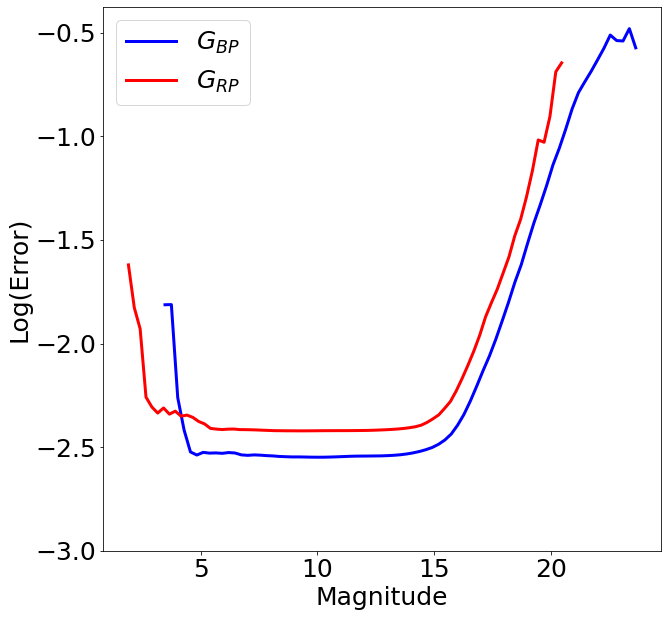

In [5]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

# APOKASC 

In [6]:
from astropy.io import ascii
kasc = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

### xmatch DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, kasc_ind, dr17_ind = np.intersect1d(kasc['2MASS_ID'],dr17['APOGEE_ID'], return_indices=True)

kascdr17 = dr17[dr17_ind]
kasc = kasc[kasc_ind]

### xmatch kasc2 and kasc3
_, kasc3_ind, kasc_ind = np.intersect1d(kasc3['2MASSID'],kasc['2MASS_ID'], return_indices=True)

kasc = kasc[kasc_ind]
kasc3dr17 = kascdr17[kasc_ind]
kasc3 = kasc3[kasc3_ind]

ageevs = np.where((kasc3['IntAge']>-10.)&(kasc['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kasc3dr17['FE_H']<=0.0)&
                  (kasc3dr17['GAIAEDR3_PARALLAX']/kasc3dr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

kasc = kasc[ageevs]
kasc3dr17 = kascdr17[ageevs]
kasc3 = kasc3[ageevs]

### Gaia BP and RP ERRs
bperr = 10**bperrfunc(kasc3dr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kasc3dr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

In [7]:
from tqdm import tqdm_notebook

kasc_ak = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_ak_err = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_age = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_age_err = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_mass = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_mass_err = 999999.0*np.ones(len(np.squeeze(ageevs)))

for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
    te = np.array([kasc3dr17['TEFF'][i],kasc3dr17['TEFF_ERR'][i]])
    ab = np.array([kasc3dr17['M_H'][i],kasc3dr17['ALPHA_M'][i]])
    op = np.array([[kasc3dr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kasc3dr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kasc3dr17['J'][i],kasc3dr17['H'][i],
                    kasc3dr17['K'][i]],
                   [bperr[i],rperr[i],kasc3dr17['J_ERR'][i],
                    kasc3dr17['H_ERR'][i],kasc3dr17['K_ERR'][i]]]).T
    di = (1/kasc3dr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
    ak_val = CalcAge.get_ak(age = 12.0)
    kasc_ak[i] = ak_val[0] #CalcAge.get_ak(age = 6.0)[0]
    kasc_ak_err[i] = ak_val[1] #CalcAge.get_ak(age = 6.0)[1]
    
    age_val = CalcAge.get_age()
    kasc_age[i] = age_val[0] #CalcAge.get_age()[0]
    kasc_age_err[i] = age_val[1] #CalcAge.get_age()[1]
    
    cgma = CalcAge.get_mass()
    kasc_mass[i] = cgma[0]
    kasc_mass_err[i] = cgma[1]

<ipython-input-7-7981a95c13aa>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-2-b8963ef34cbb>:43: RuntimeWarning: invalid value encountered in log10
  self.distmod = 5.0*np.log10(distance)-5.0


In [10]:
### save ages to fits file
from astropy.table import Table, Column
        
cname = Column(kasc3dr17['APOGEE_ID'], name='NAME')
cage = Column(kasc_age,name='AGE')
cage_err = Column(kasc_age_err,name='AGE_ERR')
# cage_flag = Column(kasc_age_flag,name='AGE_FLAG')
cak = Column(kasc_ak,name='AK')
cak_err = Column(kasc_ak_err,name='AK_ERR')
cmass = Column(kasc_mass,name='MASS')
cmass_err = Column(kasc_mass_err,name='MASS_ERR')

agetable = Table([cname,cage,cage_err,cak,cak_err]) #cage_flag
agetable.write('aetas_kasc_results.fits', format='fits', overwrite=True)

In [11]:
### Import saved ages
agetab = Table(fits.getdata('aetas_kasc_results.fits'))

# Explore Results

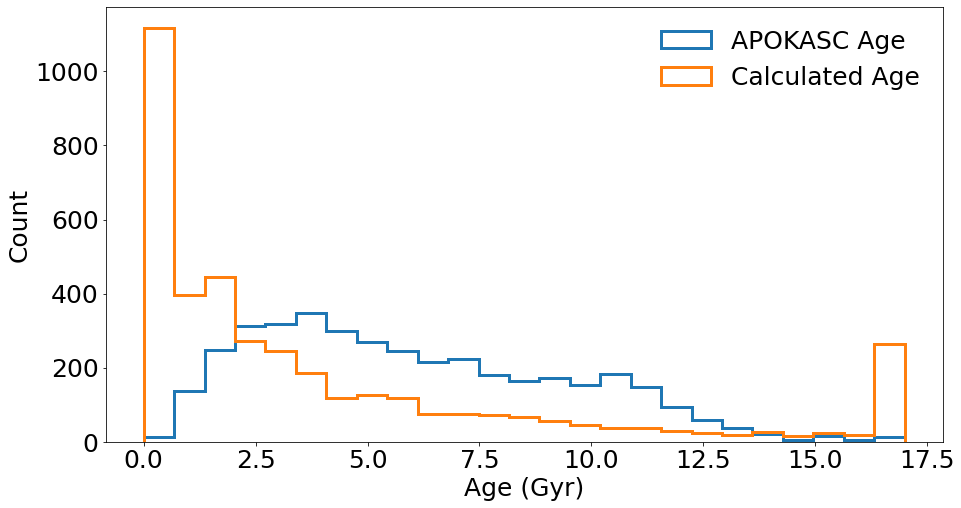

In [12]:
plt.figure(figsize=[15,8])
plt.hist(kasc3['IntAge'],range=(0,17),bins=25,density=False,histtype='step',lw=3.0,label='APOKASC Age')
plt.hist(agetab['AGE'],range=(0,17),bins=25,density=False,histtype='step',lw=3.0,label='Calculated Age')
plt.legend(frameon=False)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Count')
# plt.savefig('../plots/agehistogram_salarisCN.pdf',dpi=300,bbox_inches='tight')
plt.show()

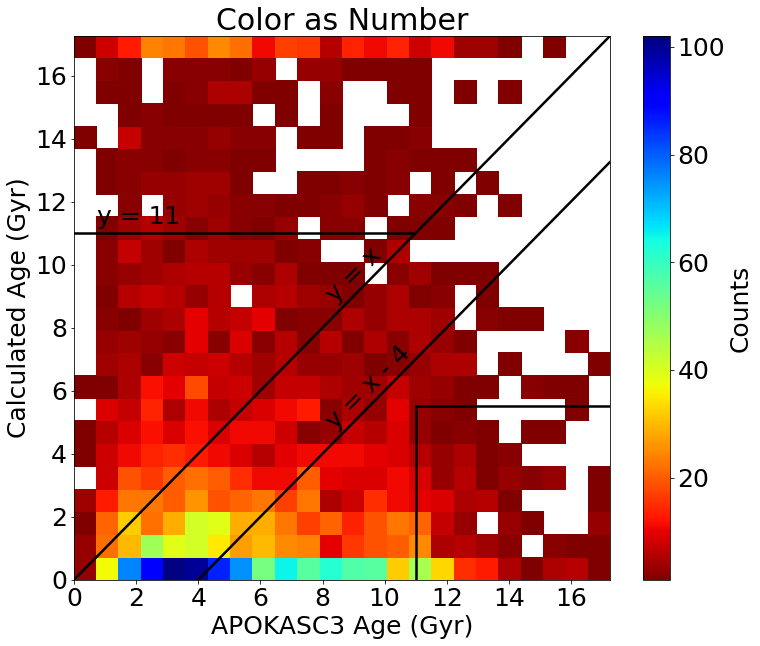

In [46]:
badcut = np.where(agetab['AGE']<999999.0)

x = kasc3['IntAge'][badcut]
y = agetab['AGE'][badcut]
xmax = 18
ymax = 18
nbins = 25

plt.figure(figsize=[12,10])
plt.hist2d(x,y,bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.title(r'Color as Number')
# plt.savefig('../plots/age_age_countCNAlpha.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [26]:
print('hello world!')

hello world!
